In [2]:
import pandas as pd
df=pd.read_csv("/kaggle/input/heart-disease-prediction/Heart_Disease_Prediction.csv")
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


        Model  Accuracy  Precision    Recall
0       Basic  0.944444   1.000000  0.857143
1  Polynomial  0.851852   0.882353  0.714286
2  Poly + PCA  0.833333   0.833333  0.714286


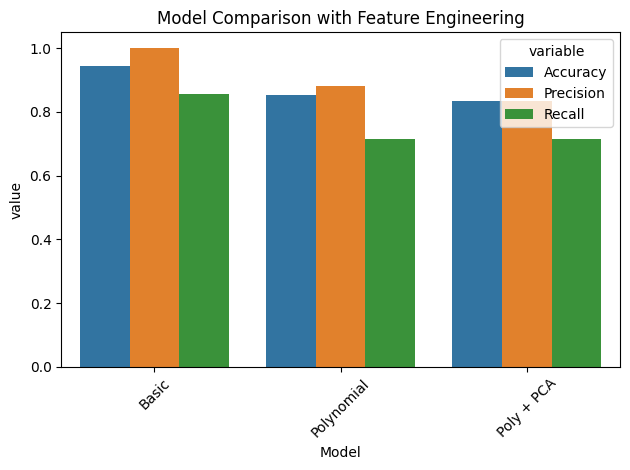

In [4]:
# 🧠 Heart Disease Prediction with Feature Engineering (Your Dataset Version)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns



# Rename target column if necessary
df['Heart Disease'] = df['Heart Disease'].map({'Presence': 1, 'Absence': 0})

# Separate features and target
X = df.drop('Heart Disease', axis=1)
y = df['Heart Disease']

# Identify categorical and numerical columns
cat_cols = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium']
num_cols = [col for col in X.columns if col not in cat_cols]

# Column transformer: scale numeric + one-hot encode categorical
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Evaluation function
def evaluate(pipe, label):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    return {
        'Model': label,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred)
    }

results = []

# 1️⃣ Basic pipeline
pipe_basic = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])
results.append(evaluate(pipe_basic, 'Basic'))

# 2️⃣ Polynomial features
pipe_poly = Pipeline([
    ('prep', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('clf', LogisticRegression(max_iter=1000))
])
results.append(evaluate(pipe_poly, 'Polynomial'))

# 3️⃣ Polynomial + PCA
pipe_pca = Pipeline([
    ('prep', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('pca', PCA(n_components=0.95)),
    ('clf', LogisticRegression(max_iter=1000))
])
results.append(evaluate(pipe_pca, 'Poly + PCA'))

# 📊 Results summary
results_df = pd.DataFrame(results)
print(results_df)

# 🔍 Visual comparison
sns.barplot(data=results_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Model Comparison with Feature Engineering")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


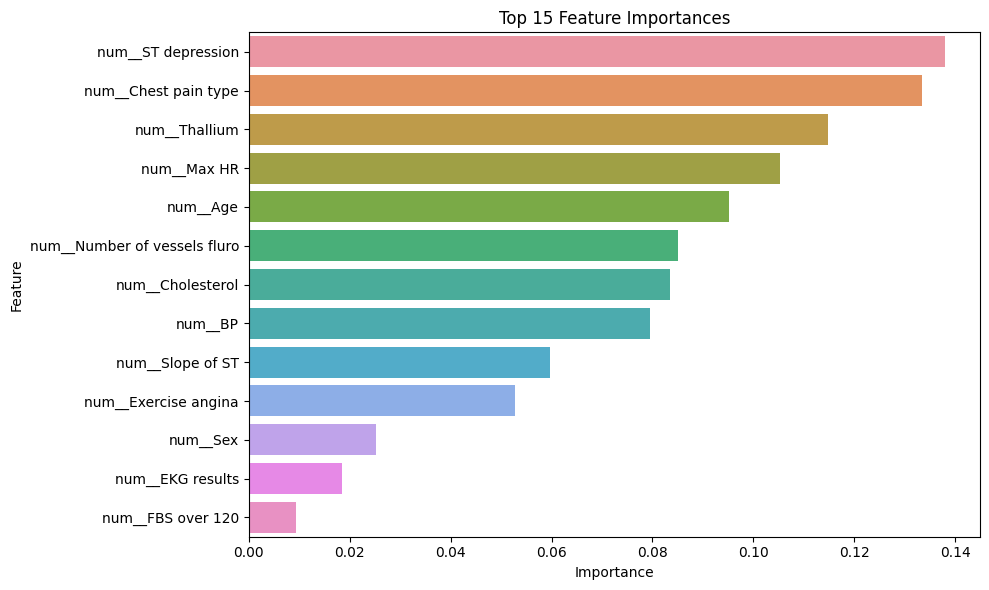

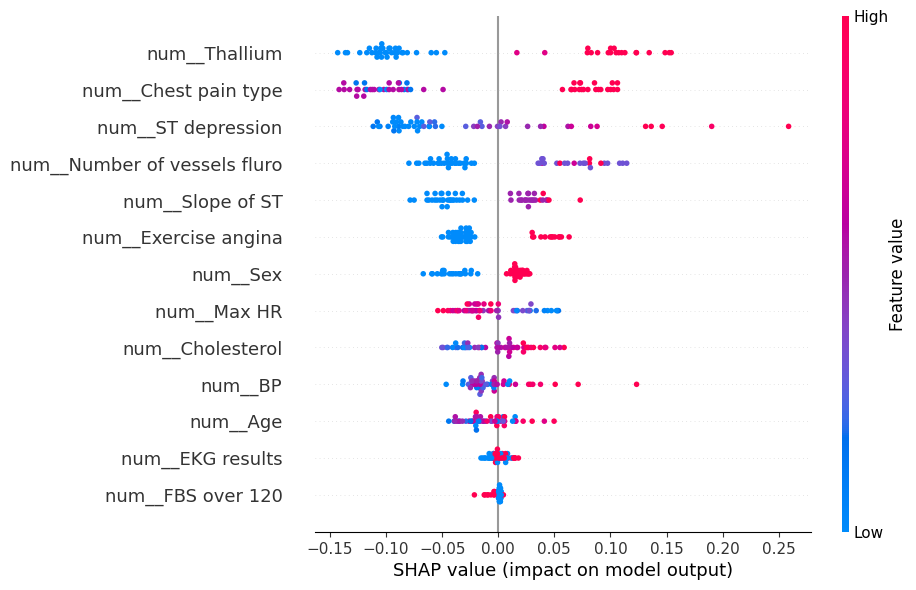

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load your dataset
df = pd.read_csv("/kaggle/input/heart-disease-prediction/Heart_Disease_Prediction.csv")  # Replace with actual path or URL

# Target encoding (ensure binary: 0 = Absence, 1 = Presence)
df['Heart Disease'] = df['Heart Disease'].map({'Presence': 1, 'Absence': 0})

# Separate features and target
X = df.drop('Heart Disease', axis=1)
y = df['Heart Disease']

# Detect categorical columns (dtype = object or string)
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Full pipeline
pipe = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
pipe.fit(X_train, y_train)

# Feature names after encoding
feature_names = pipe.named_steps['prep'].get_feature_names_out()

# Feature importances
importances = pipe.named_steps['clf'].feature_importances_
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# SHAP explainer and beeswarm plot (fixing dimensionality issue)
explainer = shap.Explainer(
    pipe.named_steps['clf'],
    pipe.named_steps['prep'].transform(X_train),
    feature_names=feature_names,
    model_output="probability"
)

# SHAP values for test set
shap_values = explainer(pipe.named_steps['prep'].transform(X_test), check_additivity=False)

# If it's multi-class, select SHAP values for class 1
if isinstance(shap_values.values, list) or shap_values.values.ndim == 3:
    class1_shap = shap_values[:, :, 1]  # Class 1 (positive class)
else:
    class1_shap = shap_values

# Beeswarm plot
shap.plots.beeswarm(class1_shap, max_display=15)
